In [1]:
import os
import os.path as osp

import numpy as np
import struct
import easydict

import open3d as o3d

import matplotlib
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from utils import save_pcd, read_kitti_lidar_bin

In [3]:
sample_index = "004369"

In [4]:
lidar_pt = read_kitti_lidar_bin(f"data/training/velodyne/{sample_index}.bin")
print(lidar_pt)
save_pcd(
    lidar_pt[:, :3],
    np.ones((len(lidar_pt), 3)) * lidar_pt[:, 3].reshape((-1, 1)),
    0.05,
    "sample"
)

[[35.11199951  4.33099985  1.40499997  0.        ]
 [78.68599701  9.98900032  2.89100003  0.        ]
 [78.71299744 10.24400043  2.89299989  0.        ]
 ...
 [ 3.79999995 -1.40400004 -1.773       0.        ]
 [16.11199951 -4.49900007 -7.68400002  0.23      ]
 [16.2329998  -4.47800016 -7.73600006  0.        ]]


![snapshot](data/images/Snipaste_2024-11-28_20-27-59.png)
![snapshot](data/images/Snipaste_2024-11-29_10-28-22.png)


# label file field explanation

- `<object_type>:` The type of the annotated object. This can be one of the following: 'Car', 'Van', 'Truck', 'Pedestrian', - 'Person_sitting', 'Cyclist', 'Tram', 'Misc', or 'DontCare'. 'DontCare' is used for objects that are present but ignored for evaluation.
- `<truncation>`: The fraction of the object that is visible. It is a float value in the range [0.0, 1.0]. A value of 0.0 means the - object is fully visible, and 1.0 means the object is completely outside the image frame.
- `<occlusion>`: The level of occlusion of the object. It is an integer value indicating the degree of occlusion, where 0 means fully - visible, and higher values indicate increasing levels of occlusion.
- `<alpha>`: The observation angle of the object in radians, relative to the camera. It is the angle between the object's heading - direction and the positive x-axis of the camera.
- `<left>, <top>, <right>, <bottom>`: The 2D bounding box coordinates of the object in the image. They represent the pixel locations of - the top-left and bottom-right corners of the bounding box.
- `<height>, <width>, <length>`: The 3D dimensions of the object (height, width, and length) in meters.
- `<x>, <y>, <z>`: The 3D location of the object's centroid in the camera coordinate system (in meters).
- `<rotation_y>`: The rotation of the object around the y-axis in camera coordinates, in radians.

see also: https://medium.com/@abdulhaq.ah/explain-label-file-of-kitti-dataset-738528de36f4

In [5]:
# label the thing with colors
def is_float(item):
    try:
        item = float(item)
    except Exception as e:
        return False
    return True

label_field_name_list = [
    "object_type",
    "truncation",
    "occlusion",
    "alpha",
    "left", "top", "right", "bottom",
    "height", "width", "length",
    "x", "y", "z",
    "rotation_y"
]
label_list = []
with open(f"data/training/label_2/{sample_index}.txt", 'r') as f:
    label_list = [tuple([float(item) if is_float(item) else item for item in line.strip().split()]) for line in f.readlines()]
# transform each label to dictionary item
label_list = [
    easydict.EasyDict({field:value for (field, value) in zip(label_field_name_list, item)}) for item in label_list
]

calib_field_name_list = [
    "P0", "P1", "P2", "P3",
    "R0_rect", "Tr_velo_to_cam", "Tr_imu_to_velo"
]
calib_info = []
with open(f"data/training/calib/{sample_index}.txt", 'r') as f:
    calib_list = [line.strip().split() for line in f.readlines() if len(line.strip()) > 0]
calib_info = easydict.EasyDict(
    {seq[0][:-1]:[float(x) for x in seq[1:]] for seq in calib_list}
)

print(*label_list, sep='\n')
for key, val in calib_info.items():
    print(key, val)

{'object_type': 'Car', 'truncation': 0.0, 'occlusion': 0.0, 'alpha': -1.65, 'left': 634.89, 'top': 184.77, 'right': 675.04, 'bottom': 213.79, 'height': 1.32, 'width': 1.63, 'length': 4.1, 'x': 2.15, 'y': 1.93, 'z': 35.89, 'rotation_y': -1.6}
{'object_type': 'Car', 'truncation': 0.0, 'occlusion': 2.0, 'alpha': 0.21, 'left': 394.31, 'top': 178.6, 'right': 507.49, 'bottom': 219.61, 'height': 1.58, 'width': 1.56, 'length': 4.25, 'x': -6.44, 'y': 1.84, 'z': 29.32, 'rotation_y': -0.0}
{'object_type': 'Car', 'truncation': 0.0, 'occlusion': 1.0, 'alpha': -0.3, 'left': 733.33, 'top': 182.14, 'right': 880.89, 'bottom': 236.7, 'height': 1.5, 'width': 1.62, 'length': 3.88, 'x': 5.71, 'y': 1.8, 'z': 21.31, 'rotation_y': -0.04}
{'object_type': 'Car', 'truncation': 0.0, 'occlusion': 2.0, 'alpha': -2.83, 'left': 202.13, 'top': 171.25, 'right': 419.02, 'bottom': 258.03, 'height': 1.77, 'width': 1.68, 'length': 4.12, 'x': -6.54, 'y': 1.76, 'z': 16.01, 'rotation_y': 3.07}
{'object_type': 'Car', 'truncati

# add label colors

Note that `<x,y,z>` coordinates in the KITTI object detection dataset are placed under the camera coordinate, if it's to be used with lidar point cloud data, you should do the coordinate transformation first

![kitti_coor](data/images/kitti_coord.png)

In [6]:
from utils import R_mat, T_vec

points = lidar_pt[:, :3]
colors = np.ones(points.shape)

anchor_points = []
anchor_colors = []
for label in label_list:
    if (label.object_type == "DontCare"):
        continue

    R_cam = R_mat(label.rotation_y, [0, 1, 0])
    T_cam = T_vec([label.x, label.y, label.z])
    
    # transform from camera coordinate to velodyn coordinate
    vly2cam = np.array(calib_info.Tr_velo_to_cam).reshape((3, 4))
    R_vly2cam = vly2cam[:3, :3]
    T_vly2cam = vly2cam[: ,  3].reshape((-1, 1))

    T_vly = R_vly2cam.T @ (T_cam - T_vly2cam)
    
    # visualize center point
    anchor_points.append(T_vly.T)
    anchor_colors.append([0.0, 1.0, 0.0])

    R_vly = R_vly2cam.T @ R_cam @ R_vly2cam

    bound_delta_ratio = 75
    w, l, h = label.width/2 + label.width/bound_delta_ratio,\
              label.length/2 + label.length/bound_delta_ratio,\
              label.height + label.height/bound_delta_ratio
    lb_vly = np.array([-w, -l, .0]).reshape((-1, 1)) # left bottom
    rt_vly = np.array([+w, +l, +h]).reshape((-1, 1)) # right top
    
    lb_tgt = R_vly @ lb_vly + T_vly
    rt_tgt = R_vly @ rt_vly + T_vly
    
    anchor_points.append(lb_tgt.T)
    anchor_points.append(rt_tgt.T)
    anchor_colors.append([1.0, 0.0, 0.0])
    anchor_colors.append([1.0, 0.0, 0.0])

    points_msk = R_vly.T @ (points.T - T_vly)

    mask = np.all((points_msk.T >= lb_vly.T) & (points_msk.T <= rt_vly.T), axis=1)
    # print(label.object_type, mask.astype(np.int32).sum())

    colors[mask] = np.array([1.0, 0.7, 0.2])

points = np.vstack([points, np.vstack(anchor_points)]) # add other points to main part
colors = np.vstack([colors, np.vstack(anchor_colors)]) # add other colors to main part
save_pcd(points, colors, 0.05, "gdth")

# bounding box segmentation result
![bbox_visualization](data/images/bbox_seg.png)

Green dots represent the center of the bottom of the bounding box, red dots represent left bottom and right top corners of the bounding box, orange dots represent the `object_type`

这里为了得到原标注文件的分割区域的可视化，花了不少功夫理解 KITTI 的相继坐标系之间的转换。原来旋转矩阵和坐标系变换矩阵并没有什么差别，是同一种仿射变换的不同称呼而一，毕竟旋转了之后的坐标其实就是用旋转后的坐标系（转换到的新坐标系）去表示原来的点而已。

# front view kitti projection

The front axis is $+X$

原论文有个投影的缺陷，就是这种球体投影方法或者说环视图投影方法依赖于反三角函数对正弦值的转换到弧度，而同一个正弦值可能有两个不同的角度，然而大部分 `arcsin` 和 `arccos` 函数都只返回其中一个象限的角度，导致比如像 KITTI 这种摄像机朝前的点云坐标表示，需要转换为球形投影或者柱形投影的时候，缺失了背后的一块信息，或者说超过 $180^\circ$ 的信息的极坐标表示会和前半球投影重叠在一起。

一种比较朴素的解决方法就是每个半球单独来处理，这里因为只需要前半球的正 $90^\circ$ 范围视角，因此只处理前半球的点云。

(375, 1242, 3)


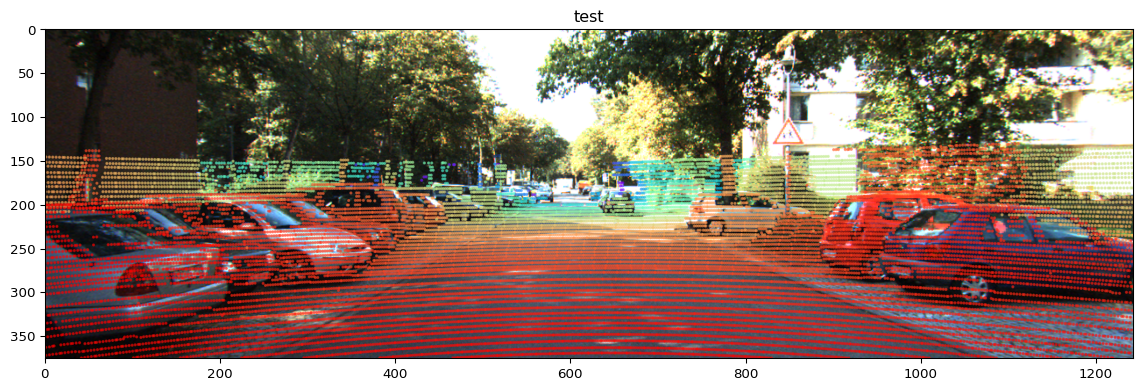

In [16]:
# https://github.com/azureology/kitti-velo2cam/blob/master/proj_velo2cam.py

import matplotlib.image


P2 = np.array(calib_info.P2).reshape((3, 4))
R0 = np.array(calib_info.R0_rect).reshape((3, 3))
TR = np.array(calib_info.Tr_velo_to_cam).reshape((3, 4))

# convert to homogeneous coordinates
R0 = np.pad(R0, ((0, 1), (0, 1)), mode="constant", constant_values=0)
R0[3][3] = 1
TR = np.pad(TR, ((0, 1), (0, 0)), mode="constant", constant_values=0)
TR[3][3] = 1

points_4xn = np.hstack([points, np.ones((points.shape[0], 1))]).T

cam = (P2 @ R0 @ TR @ points_4xn)
cam[:2] /= cam[2, :]
cam = np.delete(cam,np.where(cam[2,:]<0),axis=1)

png = matplotlib.image.imread("data/training/image_2/004369.png")
IMG_H, IMG_W, _ = png.shape # row, column, _
print(png.shape)

plt.figure(figsize=(12,5),dpi=96,tight_layout=True)

# restrict canvas in range
plt.axis([0,IMG_W,IMG_H,0])
plt.imshow(png)

u, v, z = cam
u_out = np.logical_or(u < 0, u > IMG_W)
v_out = np.logical_or(v < 0, v > IMG_H)
outlier = np.logical_or(u_out, v_out)
cam = np.delete(cam, np.where(outlier), axis=1)
# generate color map from depth
u, v, z = cam

plt.scatter([u], [v], c=[z], cmap='rainbow_r',alpha=0.5,s=2)
plt.title("test")
plt.show()

In [8]:
front_mask = points[:, 1] / np.linalg.norm(points[:, :2], axis=1)
front_mask = (front_mask > -(np.pi / 4)) & (front_mask < +(np.pi / 4)) & (points[:, 0] > 0) # 前半球方向向量和正朝向向量夹角小于45度的点
print(front_mask.astype(np.int32).sum() / len(points))
save_pcd(
    points[front_mask],
    colors[front_mask],
    out_name="front"
)

0.3034112242514426


In [9]:
# compute sphere coordinate
front_points = points[front_mask]

x = np.arcsin(front_points[:, 1] / np.linalg.norm(front_points[:, :2], axis=1))
y = np.arcsin(front_points[:, 2] / np.linalg.norm(front_points, axis=1))

field_x_range, res_x = np.pi / 2, 256
filed_y_range, res_y = np.pi / 2, 128

delta_x = field_x_range / res_x
delta_y = filed_y_range / res_y

x = x // delta_x
y = y // delta_y

sphere_coords = np.hstack([
    np.array(x).reshape((-1, 1)),
    np.array(y).reshape((-1, 1))
]).astype(np.int32)

sphere_coords -= sphere_coords.min(axis=0)
print(sphere_coords.max(axis=0), sphere_coords.min(axis=0))

[295  39] [0 0]


In [10]:
# sphere_image = np.zeros((*(sphere_coords.max(axis=0) + 1)[::-1], 3))
# for (x, y), (r, g, b) in zip(sphere_coords, colors):
#     sphere_image[y, x] = np.array([r, g, b])

# plt.figure(figsize=(512, 256))
# plt.imshow(sphere_image)